# Adaptive PDE discretizations on cartesian grids
## Volume : Non-Divergence form PDEs
## Part : Applications
## Chapter : Boat routing


In this notebook, we compute the optimal route for a boat under the following assumptions:
- The objective is to minimize the fuel consumption, for a prescribed the travel time, or window of travel times.
- The boat fuel consumption is locally a quadratic function of its relative velocity, w.r.t. water.
- The boat total velocity is the sum of the relative velocity w.r.t water and of a drift due to water currents.

**Discussion of the assumptions**

These assumptions chosen above are a strong simplification of reality. Some of them may be relaxed, at the price of more complexity in the implementation. 
- The boat velocity model can be complexified. In fact, the method described below can handle any convex cost, approximated in a suitable manner. However, determining this cost (which depends on the physical properties of the boat), and approximating it (fitting a convex set with an intersection of ellipsoids), may raise difficulties in itself. 
- The problem considered here is time dependent. However, if time dependency is not a prerequisite for the application, then a much simpler and faster alternative numerical method can be considered, described in another notebook.

**Time and space complexity**

The numerical approach presented below (time dependent problem) is orders of magnitude slover than the fast marching method discussed in the other notebook (static problem), and uses orders of magnitude more memory. However, the time dependent method should not be immediately dismissed on this account, since there are huge unexploited optimization opportunities. (Which may be illustrated in a future notebook.)
- *Time complexity.* The time dependent method is embarassingly parallel, and one may easily take advantage of GPU computing power. Speed improvements by a factor 100 are not unlikely.
- *Space complexity.* Bactracking the minimal paths requires to visit the PDE solution in reverse time. Currently, we keep a complete history of the computations, which has a huge memory cost. A more reasonable implementation would use landmarks, possibly in a recursive manner, and recompute some parts of the solution on the fly as needed.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('BoatRouting','FMM'))

In [102]:
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import Selling
from agd import AutomaticDifferentiation as ad
from agd import HFMUtils
from agd import Interpolation
from agd.Plotting import savefig; #savefig.dirName = 'Images/BoatRouting'

from agd.ExportedCode.Notebooks_FMM import BoatRouting

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Utility functions

In [4]:
norm_infinity = ad.Optimization.norm_infinity 
def norm(x): return ad.Optimization.norm(x,axis=0) # L2 norm on first axis
from agd.ExportedCode.Notebooks_NonDiv.LinearMonotoneSchemes2D import streamplot_ij

def quiver(X,Y,U,V,subsampling=1,**kwargs):
    def f(Z): return Z[::subsampling,::subsampling]
    plt.quiver(f(X),f(Y),f(U),f(V),**kwargs)

In [5]:
#from itertools import accumulate # Accumulate with initial value only exists in Python >= 3.8
def accumulate(iterable, func, initial):
    yield initial
    for element in iterable:
        initial = func(initial, element)
        yield initial

In [145]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global lp,fd,Selling,ad,Interpolation
    lp,fd,Selling,ad,Interpolation = rreload([lp,fd,Selling,ad,Interpolation],"../..")

## 1. The model and numerical scheme

Our objective is to compute the total fuel consumption $C(x,t)$, needed to reach a point $x$ at time $t$, from initial conditions (discussed below). This cost obeys the Hamilton-Jacobi-Bellman PDE
$$
    \partial_t C(t,x) + \sup_v \Big( <\nabla_x C(t,x),v> - c(t,x,v)\Big) = 0,
$$
where $c(t,x,v)$ is the instantaneous fuel consumption of a boat moving at velocity $v$, around the point $x$ and at time $t$. As announced, the time independent case $c=c(x,v)$ is best handled by a different set of methods, and is discussed in another notebook.

**Discussion on the cost function.**
For simplicity, we consider a quadratic cost, in the form
$$
    c(t,x,v) = \mu(t,x) + \frac 1 2 \|v-\omega(t,x)\|_{M(t,x)}^2,
$$
where the parameters have the following interpretation:
- $\mu(t,x)$ is the fuel consumption at rest (or any other penalization of time).
- $\omega(t,x)$ is the drift velocity.
- $M(t,x)$ is a positive definite tensor describing the domain geometry.

The numerical scheme proposed below can in principle be generalized to costs of the form 
$$
    c(t,x,v) = \sup_{\lambda\in \Lambda} a_\lambda(t,x) + <b_\lambda(t,x),v> + \|v\|^2_{c_\lambda(t,x)},
$$
where $a_\lambda$, $b_\lambda$, and $c_\lambda$ are arbitrary scalar, vector, and symmetric positive matrix. Any cost (with at least quadratic growth at infinity) can be approximated in this form.

**Elimination of the supremum in the PDE.**
Using the explicit expression of the cost function, we can simplify the HJB equation obeyed by the cost function.
In the case of the quadratic cost, we obtain 
$$
    \partial_t C(t,x) + < \nabla_x C(t,x),\omega(t,x)> + \frac 1 2 \|\nabla_x C(t,x)\|_{M(x)^{-1}}^2 - \mu(t,x) = 0
$$
The following expression will be more convenient:
$$
    \partial_t C(t,x) + \frac 1 2 \|\nabla_x C(t,x) + \eta(t,x)\|_{D(t,x)}^2 = \nu(t,x),
$$
where $D(t,x) = M(t,x)^{-1}$, $\eta(t,x) = M(t,x)\omega(t,x)$ and $\nu(t,x) = \mu(t,x) + \frac 1 2 \|\omega(t,x)\|_{M(t,x)}^2.$

In the case of the general cost, one can also eliminate the sup in the PDE, by interverting a sup and an inf, under suitable assumptions.

**Numerical scheme.**
We use an explicit scheme, which is monotone under a CFL condition. The key difficulty lies in the discretization of the quadratic first order term, which we do as follows
$$
    \|\nabla C(t,x)+\eta(t,x)\|^2_{D(x)} = \sum_{1 \leq i \leq n} \lambda_i(t,x) 
    \max\Big(0, \frac{C(t,x)-C(t,x-he_i)}h + <\eta(t,x),e_i>, \frac{C(t,x)-C(t,x+he_i)} h - <\eta(t,x),e_i>\Big)^2 + O(h).
$$
We denoted by $(\lambda_i,e_i)_{i=1}^n$ a decomposition of the tensors
$$
    D(t,x) = \sum_{1 \leq i \leq n} \lambda_i(t,x) e_i e_i^T,
$$
where $\lambda_i \geq 0$ and $e_i \in Z^d$. In practice, we use Selling's decomposition, so that $n=d (d+1)/2$, and more specifically $d=2$ and $n=3$.

**Boundary conditions.**
We assign an infinite cost to all points outside the domain, a.k.a outflow boundary conditions. In other words, the boat trajectories are constrained to remain within the domain.

In [7]:
def scheme_params(model_params):
    μ,ω,M = fd.common_field(model_params, depths=(0,1,2))    
    D = lp.inverse(M)
    η = lp.dot_AV(M,ω)
    ν = μ + 0.5*lp.dot_VAV(ω,M,ω)
    
    λ,e = Selling.Decomposition(D)
    return (ν,η,D,λ,e)

def Scheme(C,dt,dx,params,walls=False):
    C,β,η,_,λ,e = fd.common_field((C,)+params, depths=(0,0,1,2,1,2))
    η = np.expand_dims(η,axis=1)
                                  
    dCm = -fd.DiffUpwind(C,-e,dx,padding=np.inf) + lp.dot_VV(η,e)
    dCp = -fd.DiffUpwind(C, e,dx,padding=np.inf) - lp.dot_VV(η,e)
    dCNorm = (λ * np.maximum(0.,np.maximum(dCp,dCm))**2).sum(axis=0)

    return np.where(walls,np.inf, C + dt*(β - 0.5*dCNorm))

**Initialization.** 
From the modeling standpoint, one would like to initialize the fuel consumption at $0$ at the seed point, and $+\infty$ anywhere else. Unfortunately, the considered numerical scheme cannot handle such initial conditions, and will immediately produce NaNs.

Instead, we propose an initialization in the following form, assuming the seed point is the origin,
$$
    C(0,x) = K\|x\|,
$$
where the constant $K$ is chosen large enough so that all optimal paths of interest end up at the origin.
(TODO : quantify the value of $K$.)

**CFL stability condition**
The numerical scheme is monotone provided the time step obeys $K_0\delta t < \delta x$, where $K_0$ depends on the Lipschitz constant of the solution, and on the parameters $\omega$ and $M$. (TODO : quantify the value of $K_0$.)

**Stability of the Lipschitz constant**
If the initial condition is $K$-Lipschitz, and $K\geq K_1$ where $K_1$ depends on the parameters $\omega$ and $M$, then continuous solution remains $K$-Lipschitz at all times. Likewise for the numerical solution provided the time step obeys the CFL condition. 
(TODO : quantify $K_1$, which involves the Lipschitz constants of $\omega$ and $M$)

In [8]:
def CFL(K,dx,params):
    _,η,_,λ,e = params
    K_0 = (K+norm(η))*(λ*norm(e)).sum(axis=0)
    return dx/np.max(K_0)

## 2. Constant medium in space and time

We validate the numerical scheme by considering a constant medium, in space and time, for which we know the exact solution.

In [9]:
# Parameters : unit weight for time, unit horizontal drift, euclidean geometry
model_params = (1.,np.array((1.,0.)),np.eye(2))
params = scheme_params(model_params) 

# Coordinate system
aX,dx = np.linspace(-1,1,retstep=True)
X = np.meshgrid(aX,aX,indexing='ij')

# Initial condition
K_Lip = 3.
C_initial = K_Lip * ad.Optimization.norm(X,axis=0)
dt = CFL(K_Lip,dx,params)

### 2.1 Formal checks

Let us perform some basic checks on the scheme. First, it must preserve positivity.

In [10]:
C1 = Scheme(C_initial,dt,dx,params)
print(f"Smallest and largest value after one step : {np.min(C1)}, {np.max(C1)}")
assert np.min(C1)>=0 and np.isfinite(np.max(C1))

Smallest and largest value after one step : 0.09168654463508756, 4.23596965297735


Second, it is a monotone scheme.

In [11]:
C_initial_ad = ad.Sparse.identity(constant=C_initial)
C1_ad = Scheme(C_initial_ad,dt,dx,params)
C1_ad.simplify_ad()

print(f"Smallest and largest jacobian coefficient after one step : {np.min(C1_ad.coef)}, {np.max(C1_ad.coef)}")
assert np.min(C1_ad.coef)>=0 and np.isfinite(np.max(C1_ad.coef))

Smallest and largest jacobian coefficient after one step : 0.0, 1.0


Monotony is invalidated if we choose an excessively large time step, not obeying the CFL condition. (Which is not sharp btw.)

In [12]:
C_initial_ad = ad.Sparse.identity(constant=C_initial)
C1_ad = Scheme(C_initial_ad,2*dt,dx,params)
C1_ad.simplify_ad()
print(f"Smallest and largest jacobian coefficient after one step : {np.min(C1_ad.coef)}, {np.max(C1_ad.coef)}")

Smallest and largest jacobian coefficient after one step : -0.2996128269073922, 1.0


## 2.2 Comparison with an exact solution

A formal analysis, led in another notebook, yields the optimal route in a constant medium in space and time

In [13]:
route = BoatRouting.route_min(X,model_params)

In particular, we know the time of the longest optimal path.

In [14]:
t_max = np.max(route['time'])
t_range = np.arange(0,t_max+dt,dt)

In [15]:
C_solution = np.array(list(accumulate(
    t_range[1:],
    initial=C_initial, 
    func=lambda C_t,t: Scheme(C_t,dt,dx,params)
)))

In [16]:
assert np.allclose(C_solution[0],C_initial) and np.allclose(C_solution[1],C1)

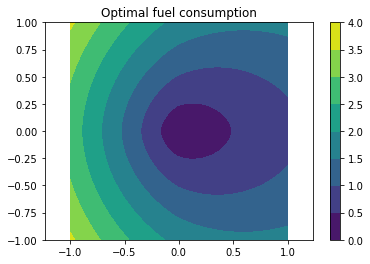

In [17]:
C_opt = np.min(C_solution,axis=0); 
plt.title("Minimal fuel consumption"); plt.axis('equal')
plt.contourf(*X,C_opt); plt.colorbar();

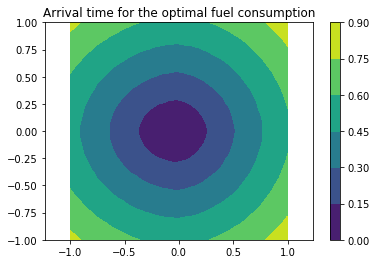

In [18]:
t_opt = t_range[np.argmin(C_solution,axis=0)]
plt.title("Arrival time for the minimal fuel consumption"); plt.axis('equal')
plt.contourf(*X,t_opt); plt.colorbar();

The numerical solution agrees with the exact solution, up to discretization error. Note that the scheme is only first order in space and time.

In [19]:
C_error = norm_infinity(C_opt-route['cost'])
t_error = norm_infinity(t_opt-route['time'])
print(f"Error on the optimal cost: {C_error}, and on the arrival time for the optimal cost: {t_error}")

Error on the optimal cost: 0.20104703516072542, and on the arrival time for the optimal cost: 0.07942048941013019


In [20]:
assert C_error<0.25 and t_error<0.1

## 2. Varying medium in space, constant in time

We choose a constant medium in time, varying in space, so as to be able to compare our results with the static approach based on the fast marching algorithm. The test case is the same as in the other notebook.

In [25]:
hfmIn = HFMUtils.dictIn({
    'verbosity':0,
    'model':'Rander2', # Riemannian + drift, what is needed here
    'exportValues':1,
    'exportGeodesicFlow':1,
    'seeds':[[-1.7,0.6]], # Where to start the front propagation
})
hfmIn.SetRect([[-2,2],[-1,1]],dimx=200) # Rectangular domain
X = hfmIn.Grid() # Coordinate system
hfmIn.update({
    'tips':hfmIn.Grid(dims=(6,3)).reshape(2,-1).T, # Points from which to backtrack geodesics
    'walls':X[1]-np.abs(X[0])>=0, # Obstacles in the domain
})

In [26]:
Embed_ω = BoatRouting.Currents(*X)
Embed_M = BoatRouting.IntrinsicMetric(BoatRouting.Spherical,*X)
model_params = (1.,Embed_ω,Embed_M)
params = scheme_params(model_params)

We compute a reference solution based on the fast marching algorithm.

In [27]:
arrival_time,hfmOut = BoatRouting.ArrivalTime(hfmIn,params)

In [77]:
K_Lip = 3.
C_initial = K_Lip * norm(X- fd.as_field(hfmIn['seeds'][0],hfmIn.shape))
C_initial[hfmIn['walls']] = np.inf
dx = hfmIn['gridScale']
dt = CFL(K_Lip,dx,params)

t_max = np.nanmax(arrival_time) # Cheating a bit: the latest arrival time is already known
t_range = np.arange(0,t_max+dt,dt)

In [86]:
# May take a few seconds
C_solution = np.array(list(accumulate(
    t_range[1:],
    initial=C_initial, 
    func=lambda C_t,t: Scheme(C_t,dt,dx,params,walls=hfmIn['walls'])
)))

In [87]:
C_opt = np.min(C_solution,axis=0)
t_opt = t_range[np.argmin(C_solution,axis=0)]

The arrival times computed by both methods match fairly well in the average. The largest difference arises where close to the cut-locus. This is not surprising, since the arrival time is discontinuous along a line in this region.

In [84]:
t_diff_avg = np.nanmean(np.abs(t_opt - arrival_time))
print(f"Average absolute difference of the arrival times {t_diff_avg}")

Average absolute difference of the arrival times 0.05123031291537425


In [85]:
assert t_diff_avg < 0.1

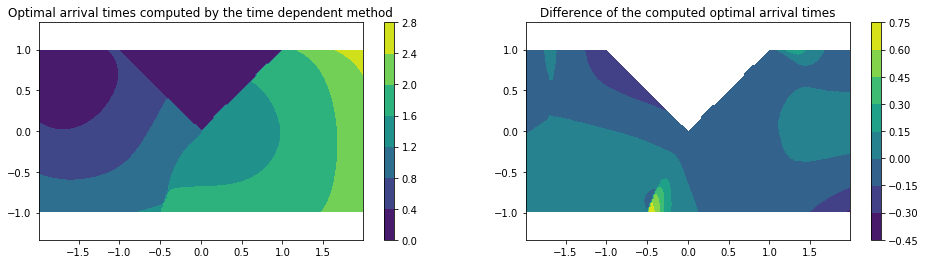

In [89]:
plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title("Optimal arrival times computed by the time dependent method")
plt.contourf(*X,t_opt); plt.colorbar()

plt.subplot(1,2,2); plt.axis('equal')
plt.title("Difference of the computed optimal arrival times")
plt.contourf(*X,t_opt-arrival_time); plt.colorbar();

The computed costs agree well in the west. Much less in the east.

The reason, I expect, is that the strong current in the east induces very strong anisotropy in the problem. As a result, the fast-marching method uses rather wide stencils, which decrease its accuracy in this region. (We use FM-ASR, fast-marching using adaptive stencil refinement.) 
The GPU eikonal solver is based on a different numerical scheme, which may agree better here. (TODO: check)

In [94]:
walls = hfmIn['walls']
C_opt[walls] = np.nan; hfmOut['values'][walls] = np.nan
C_diff_avg = np.nanmean(np.abs(C_opt - hfmOut['values']))
C_diff_avg_west = np.nanmean(np.abs(C_opt - hfmOut['values'])*(X[0]<=0))

In [98]:
print(f"Average difference of cost in the west {C_diff_avg_west}, overall {C_diff_avg}")

Average difference of cost in the west 0.09490848263388514, overall 0.6618342045088004


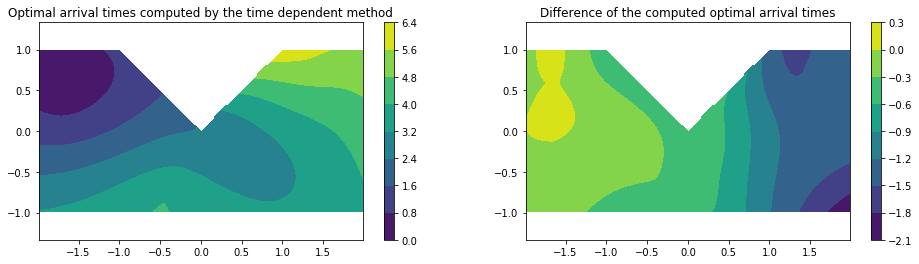

In [99]:
plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title("Optimal arrival times computed by the time dependent method")
plt.contourf(*X,C_opt); plt.colorbar()

plt.subplot(1,2,2); plt.axis('equal')
plt.title("Difference of the computed optimal arrival times")
plt.contourf(*X,C_opt-hfmOut['values']); plt.colorbar();

## 3. Extracting the optimal paths

The velocity $v$ of the boat, along the optimal trajectory at a time $t$ and position $x$, is characterized by the equation
$$
    \nabla_x C(t,x) = \nabla_v c(t,x,v).
$$
Specializing to the quadratic cost, we obtain 
$$
    \nabla_x C(t,x) = M(t,x) (v - \omega(t,x)),
$$
equivalently, with $D = M^{-1}$ and $\eta = M \omega$,
$$
    v = D(t,x) (\nabla_x C(t,x) + \eta(t,x) ).
$$


In [146]:
ReloadPackages()

In [191]:
def as_fieldT(array,st,sx,depth):
    """
    Broadcast an array, if needed, as a time dependent field.
    st : number of time steps, sx : shape w.r.t x
    """
    s = array.shape[depth:]
    vdim = len(sx)
    if   len(s)==0:    s = (1,)*(vdim+1)
    elif len(s)==1:    s = s+(1,)*vdim
    elif len(s)==vdim: s = (1,)+s
    r = array.shape[:depth]
    return np.broadcast_to(np.reshape(array,r+s),r+(st,)+sx)

In [192]:
def flow(T,X,values,η,D):
    """
    Return a callable providing the velocity of the minimal path at each time and position.
    η and D expected to be time and space dependent, broadcasted otherwise.
    """
    grid = {'shape':(len(T),)+X.shape[1:], # We do not generate the full grid, to save memory
            'origin':(T[0],)+tuple(X[:,0,0]),
            'scale':(T[1]-T[0],) + tuple(X[:,1,1]-X[:,0,0]),}
    η = as_fieldT(η,len(T),X.shape[1:],depth=1)
    D = as_fieldT(D,len(T),X.shape[1:],depth=2)    
    values,η,D = (Interpolation.UniformGridInterpolation(grid,e) for e in (values,η,D))
    def call(t,x): 
        t=np.expand_dims(t,axis=0) # for concatenation
        tx = np.concatenate((t,x),axis=0)
        η_ = η(tx); D_ = D(tx)
        x_ad = ad.Dense.identity(constant=x, shape_free=(len(x),))
        tx_ad = np.concatenate((t,x_ad),axis=0) # Differentiate value w.r.t x only
        grad_x = values(tx_ad).gradient()
        return lp.dot_AV(D_,grad_x + η_)
    return call

In [193]:
_,η,D,_,_ = params
flow_ = flow(t_range,X,C_solution,η,D)

In [190]:
flow_(0.5,(0.5,0.))

array([ 3.96967794, -0.25629048])

In [ ]:
def 

## 4. Varying medium in space and time

In [120]:
as_fieldT(np.zeros((2,1,2)),5,(3,2),1).shape

(2, 5, 3, 2)

In [166]:
x=ad.Dense.identity((2,))

In [170]:
np.stack((x,2*x)).shape

(2, 2)

In [175]:
np.concatenate((ad.remove_ad(x)+1,2*x),axis=0)

denseAD(array([1., 1., 0., 0.]),
array([[0., 0.],
       [0., 0.],
       [2., 0.],
       [0., 2.]]))

In [176]:
np.ndim(x)

1